# Read the data

In [1]:
import hpbandster

In [2]:
from collections import Counter

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [5]:
train = pd.read_csv('./Train_resampeled.csv',sep = ',')
vali = pd.read_csv('./vali.csv',sep = ',')
test = pd.read_csv('./test.csv',sep = ',')

In [6]:
train

,heart_rate,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F9_diff,F10_diff,F11_diff,F12_diff,F13_diff,F14_diff,F15_diff,F16_diff,F17_diff,id_n
0,-0.293389,-1.596303,1.082171,0.626207,0.495311,1.077173,0.699129,0.493859,-0.000798,-0.015046,...,0.000006,-6.890044e-07,0.000022,-0.000102,0.000085,0.000047,0.000038,-0.000060,-0.000027,0
1,-0.293389,-1.596303,1.094032,0.550627,0.534407,1.081335,0.645581,0.497862,-0.131029,-0.027897,...,-0.007734,5.759856e-04,0.041374,-0.001810,-0.087703,0.000047,0.000038,-0.000060,-0.000027,0
2,-0.293389,-1.596303,1.093868,0.484495,0.554000,1.080704,0.582150,0.498131,-0.182925,-0.043047,...,-0.016860,4.297381e-03,0.007845,0.035046,0.044016,0.000047,0.000038,-0.000060,-0.000027,0
3,-0.293389,-1.596303,1.082589,0.484651,0.572879,1.073279,0.528683,0.521092,-0.147567,-0.034721,...,-0.011845,8.799217e-03,0.063223,0.032597,-0.054896,0.000047,0.000038,-0.000060,-0.000027,0
4,-0.293389,-1.596303,1.095440,0.498977,0.620970,1.071020,0.526723,0.540042,-0.051664,-0.074420,...,-0.035758,5.643594e-03,0.014267,0.049558,-0.010278,0.000047,0.000038,-0.000060,-0.000027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932660,-0.990707,0.227695,0.283188,-0.329295,1.874324,0.288860,-0.342128,1.899203,0.419458,-0.493227,...,-0.368439,-3.955486e-01,-0.101137,-0.175235,-0.028186,-0.373321,-0.074700,0.171876,0.068398,6
1932661,-0.572316,0.957295,-0.145139,-0.378209,0.969388,-0.117473,-0.410484,0.970611,-0.700480,-0.041169,...,-0.046492,3.013956e-01,-0.890420,-0.509617,-0.797671,-2.633374,0.343844,0.278192,-1.037099,6
1932662,-0.607182,1.358575,0.776464,0.369185,0.509236,0.814550,0.522653,0.627493,2.340747,-0.857353,...,-0.919119,-1.780967e-01,0.067390,0.899992,-1.427978,1.519997,0.273182,-0.838990,0.042014,6
1932663,0.264466,0.519535,-0.739429,0.214571,-0.821217,-0.723633,0.325109,-1.322911,0.567056,0.091180,...,-0.492556,-7.577915e-02,0.248521,0.495615,0.417057,-0.452327,0.316306,-0.437469,0.412535,6


# batch_generator

In [7]:
def batch_generator_1(data, sequence_length=15, window_size = 10, sliding = 10):
    #batch_number = data.shape[0]/(sequence_length+window_size-1)
    feature_number = data.shape[1]-1
    window_number = int((data.shape[0]-window_size)/sliding)
    temp_shape = (window_number, window_size, data.shape[1])
    temp = np.zeros(shape=temp_shape, dtype=np.float32)
    for window in range(window_number):
        temp[window] = data.iloc[window*sliding:window*sliding+window_size,:]
        
    return temp

def batch_generator(temp,sequence_length,window_size):
    feature_number = temp.shape[2]-1
    batch_number = int(temp.shape[0]/sequence_length)
    x_shape = (batch_number, sequence_length, window_size, feature_number)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (batch_number, sequence_length, window_size)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    for Batch in range(batch_number):
        for seq in range(sequence_length):
            x_batch[Batch,seq] = temp[Batch*sequence_length+seq,:,:-1]
            #y_batch[Batch] = max(temp[Batch*sequence_length:Batch*sequence_length-1,:,-1],key=temp[Batch*sequence_length:Batch*sequence_length-1,:,-1].tolist().count)
            y_batch[Batch,seq] = temp[Batch*sequence_length+seq,:,-1]
    return x_batch, y_batch

In [8]:
sequence_length = 20
window_size = 109
kernel_size = 3
sliding = 5

In [9]:
train = batch_generator_1(train,sequence_length=sequence_length, window_size=window_size,sliding = sliding)

In [10]:
train.shape

(386511, 109, 37)

In [11]:
x_batch, y_batch= batch_generator(train,sequence_length=sequence_length, window_size=window_size)
x_batch = np.expand_dims(x_batch, axis=4)

In [12]:
x_batch.shape

(19325, 20, 109, 36, 1)

In [13]:
def y_batch_generator(y_batch,sequence_length=15,num_classes=7):
    batch_number = y_batch.shape[0]
    y_batch_n = y_batch
    y_shape = (batch_number, sequence_length)
    y_new = np.zeros(shape=y_shape, dtype=np.float32)
    y_batch_new_shape = (batch_number,sequence_length,num_classes)
    y_batch_new = np.zeros(shape=y_batch_new_shape, dtype=np.float32)
    y_temp = y_batch_n.tolist()
    for batch in range(batch_number):
        for seq in range(sequence_length):
            temp_1 = list(Counter(y_temp[batch][seq]).most_common(1))
            y_new[batch,seq]=list(temp_1[0])[0]
        y_batch_new[batch] = tf.keras.utils.to_categorical(y_new[batch],num_classes=num_classes)
        
    return y_batch_new
        
        

In [14]:
y_batch = y_batch_generator(y_batch,sequence_length = sequence_length)

In [15]:
y_batch.shape

(19325, 20, 7)

# Batch generator for vali-set

In [16]:
vali = batch_generator_1(vali,sequence_length=sequence_length, window_size=window_size)

In [17]:
x_batch_vali, y_batch_vali= batch_generator(vali,sequence_length=sequence_length, window_size=window_size)

In [18]:
x_batch_vali = np.expand_dims(x_batch_vali, axis=4)

In [19]:
y_batch_vali = y_batch_generator(y_batch_vali,sequence_length=sequence_length)
y_batch_vali = np.array(y_batch_vali)

In [20]:
y_batch_vali.shape

(1645, 20, 7)

# Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from ConvLSTM2D_2 import ConvLSTM2D_2

## self-attention

In [54]:
from ConvLSTM2D_2 import ConvLSTM2D_2
#from self_attention import self_attention
import tensorflow as tf
from tensorflow.keras import layers



class self_attention(layers.Layer):
    """
    input_shape should be a 5 dimensional tensor
    input_shape = batch_size * timestep * row * feature * channels
    feature should be 1 after the Conv_LSTM
    the input will have to rehape first 
    shape = batch_size * [timestep*row*feature] * channels
    [timestep*row*feature] ist the time feature
    output_shape is 3D tensor
    this layer apply the attention mechanismus on channels with time feature
    
    if key_value = True
        the key and value are the same
        key = value = input
    if key_value = False
        key = input x key_weight
        value = input x value_weight
    query = input x query_weights
    score = dot_product(query, key)
    Calculate softmax(score)
    alignment_vectors = value * score
    output = sum(alignment_vectors of all input)
    output is 3D
    
    """

    def __init__(self, 
                 key_value = False,):
        super(self_attention, self).__init__()
        self.key_value = key_value

        
    def build(self,input_shape):
        
        self.key_weight = self.add_weight(shape = (1,input_shape[1], input_shape[2]),
                                          initializer = 'random_normal',
                                          name = 'key_weight',
                                          trainable=True)
        
        self.value_weight = self.add_weight(shape = (1,input_shape[1], input_shape[2]),
                                          name = 'random_normal',
                                            initializer = 'random_normal',
                                            trainable=True)
        
        self.query_weight = self.add_weight(shape = (1,input_shape[1], input_shape[2]),
                                          name = 'query_weight',
                                            initializer = 'random_normal',
                                            trainable=True)
        
        
    def call(self, inputs):
        #print(inputs.shape)
        inputs = tf.transpose(inputs,perm =[0,2,1])
        
        query = tf.matmul(inputs,self.query_weight)
        #print(query.shape)
        
        value = tf.matmul(inputs,self.value_weight)
        #value = inputs
        
        #key = inputs
        key = tf.matmul(inputs,self.key_weight)
        
        key_r = tf.transpose(key,perm=[0, 2, 1])
        #print(key_r.shape)
        
        score = tf.matmul(query,key_r)
        #print(key_r.shape)
        
        score_soft = tf.nn.softmax(score, axis = 2)
        
        score_r = tf.transpose(score_soft,perm=[0, 2, 1])
        
        outputs = value[:,:,None]*score_r[:,:,:,None]
        
        output = tf.keras.backend.sum(outputs,axis=1)
        #print(output.shape)
        
        return output


## Visualization

In [55]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


## build model

In [56]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=18, kernel_size=(kernel_size,  x_batch.shape[3]),cov_kernel_size=(kernel_size, 1),input_shape=(None, window_size, x_batch.shape[3], 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
# model.add(ConvLSTM2D_2(filters=36, kernel_size=(kernel_size, 1),cov_kernel_size=(kernel_size, 1),padding='valid', return_sequences=True))
# model.add(keras.layers.BatchNormalization())
model.add(tf.keras.layers.Reshape((18*105,sequence_length)))
model.add(self_attention())
model.add(TimeDistributed(Flatten()))

#model.add(Flatten())
model.add(TimeDistributed(Dense(units = 50, activation = "linear")))
model.add(tf.compat.v2.keras.layers.Dropout(0.7))
#model.add(TimeDistributed(Dense(units = 2, activation = "softmax")))
model.add(TimeDistributed(Dense(units = 7, activation = "softmax")))
model.compile( loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='Adam',metrics=[tf.keras.metrics.CategoricalAccuracy(np.argmax(y_batch_vali, axis=2).all())])

AxisError: axis 2 is out of bounds for array of dimension 1

In [53]:
print(model.summary())

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [34]:
history = LossHistory()

In [35]:
model.fit(x_batch, y_batch,
            batch_size=10, epochs=10,
            verbose=1, 
            validation_data=(x_batch_vali, y_batch_vali),
            callbacks=[history])


Train on 19325 samples, validate on 1645 samples
Epoch 1/10
19325/19325 [==============================] - 155s 8ms/sample - loss: 0.9759 - categorical_accuracy_2: 0.6593 - val_loss: 2.3818 - val_categorical_accuracy_2: 0.4042
Epoch 2/10
19325/19325 [==============================] - 123s 6ms/sample - loss: 0.5609 - categorical_accuracy_2: 0.8228 - val_loss: 2.1597 - val_categorical_accuracy_2: 0.3167
Epoch 3/10
19325/19325 [==============================] - 121s 6ms/sample - loss: 0.5260 - categorical_accuracy_2: 0.8392 - val_loss: 2.1540 - val_categorical_accuracy_2: 0.4422
Epoch 4/10
19325/19325 [==============================] - 121s 6ms/sample - loss: 0.7106 - categorical_accuracy_2: 0.7760 - val_loss: 1.2804 - val_categorical_accuracy_2: 0.5565
Epoch 5/10
19325/19325 [==============================] - 122s 6ms/sample - loss: 0.8061 - categorical_accuracy_2: 0.7423 - val_loss: 1.5612 - val_categorical_accuracy_2: 0.5452
Epoch 6/10
19325/19325 [==============================] - 122

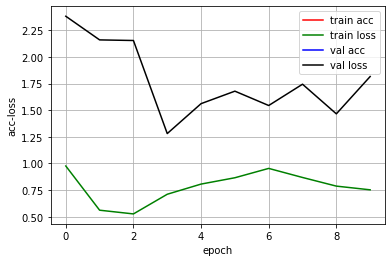

In [36]:
history.loss_plot('epoch')

# caculate the score

In [37]:
y_pre_vali = model.predict(x_batch_vali)

In [38]:
out = np.argmax(y_pre_vali, axis=2)

In [39]:
out =out.flatten()

In [40]:
out.shape

(32900,)

In [41]:
y_batch_vali = np.argmax(y_batch_vali, axis=2)

In [42]:
y_batch_vali=y_batch_vali.flatten()

In [43]:
from sklearn.metrics import precision_recall_fscore_support

In [44]:
precision, recall, fscore, support = precision_recall_fscore_support(y_batch_vali, out, average="macro")

In [45]:
fscore

0.45955164479147687

# plot 

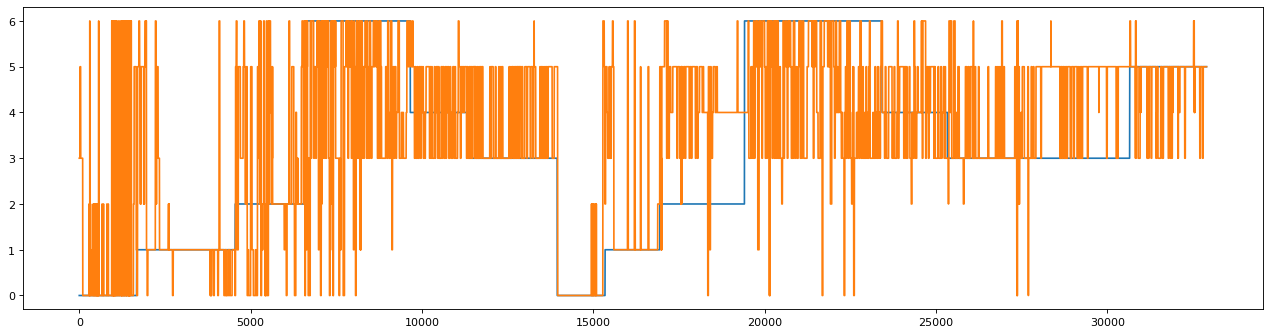

In [46]:
fig = plt.figure(num=1, figsize=(20, 5),dpi=80)
plt.plot(y_batch_vali)
plt.plot(out)



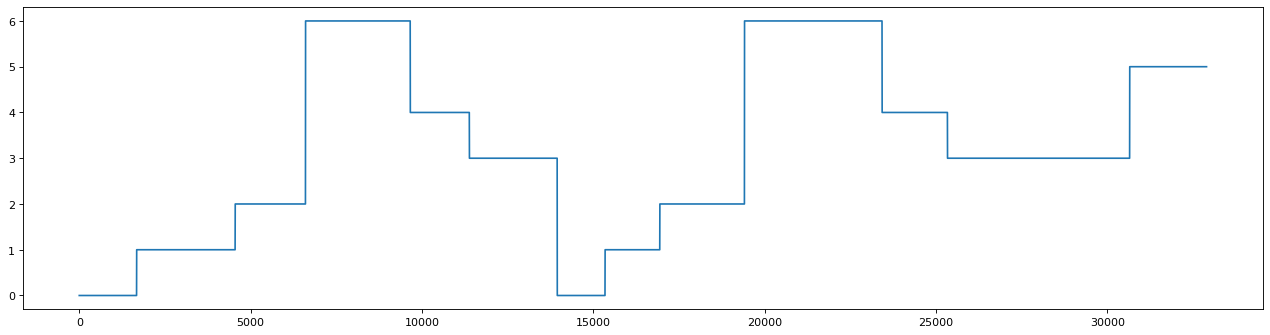

In [47]:
fig = plt.figure(num=1, figsize=(20, 5),dpi=80)
plt.plot(y_batch_vali)